<a href="https://colab.research.google.com/github/Pathway2008/CarPrice/blob/main/fillna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
배터리용량 nan 값 채우기 - 모델 iX, EV6는 제외 / 4번 IONIQ - cat+lgb, 나머지 xgb로 예측
'''

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.font_manager as fm
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import shap

In [27]:
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [45]:
train = pd.read_csv('/content/drive/MyDrive/CarPrice/new_car/train.csv')
test = pd.read_csv('/content/drive/MyDrive/CarPrice/new_car/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/CarPrice/new_car/sample_submission.csv')

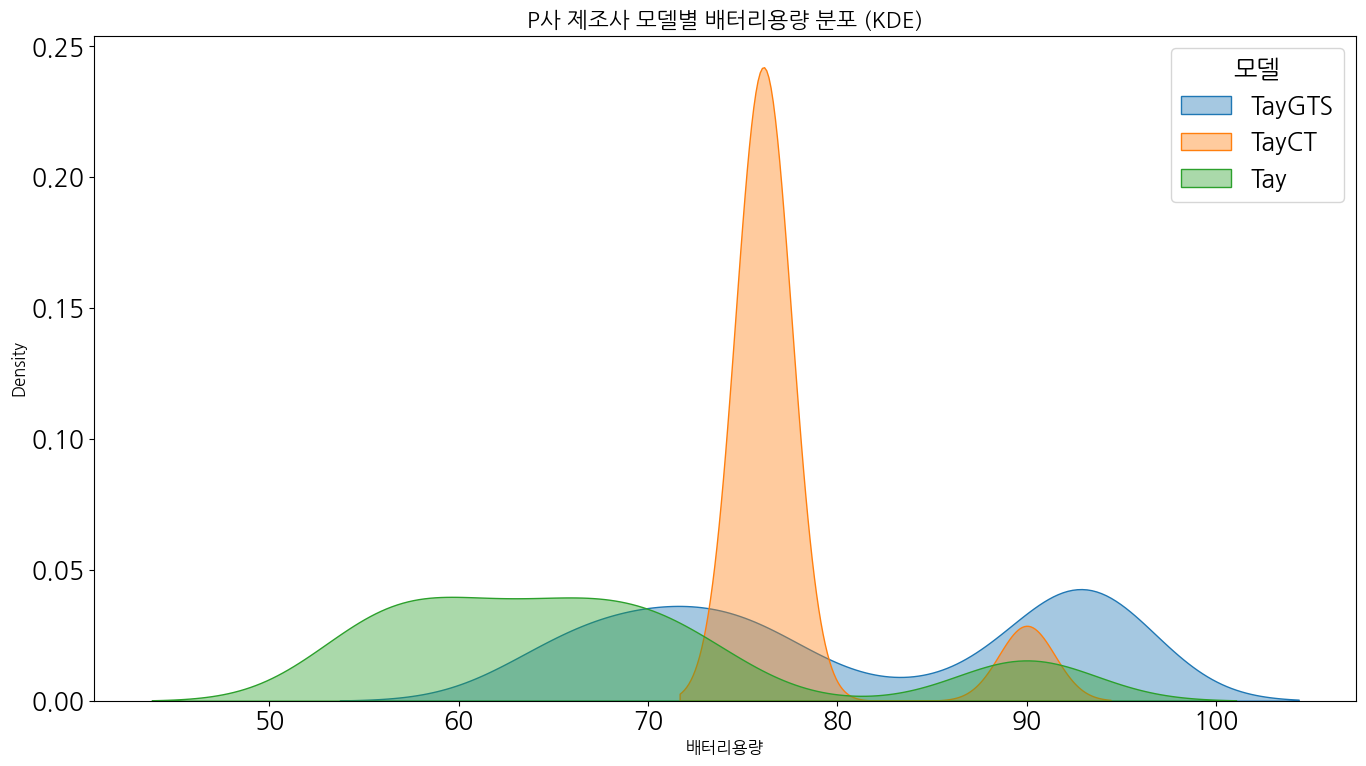

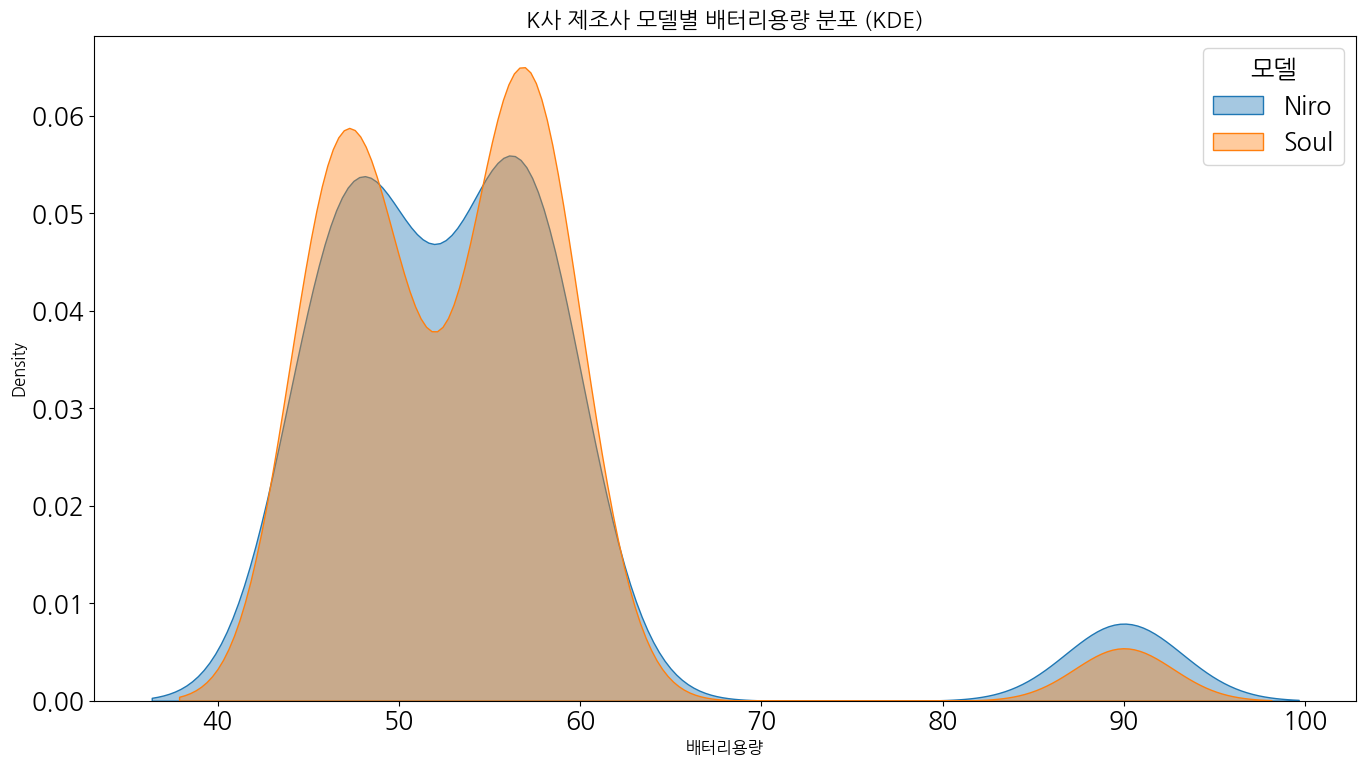

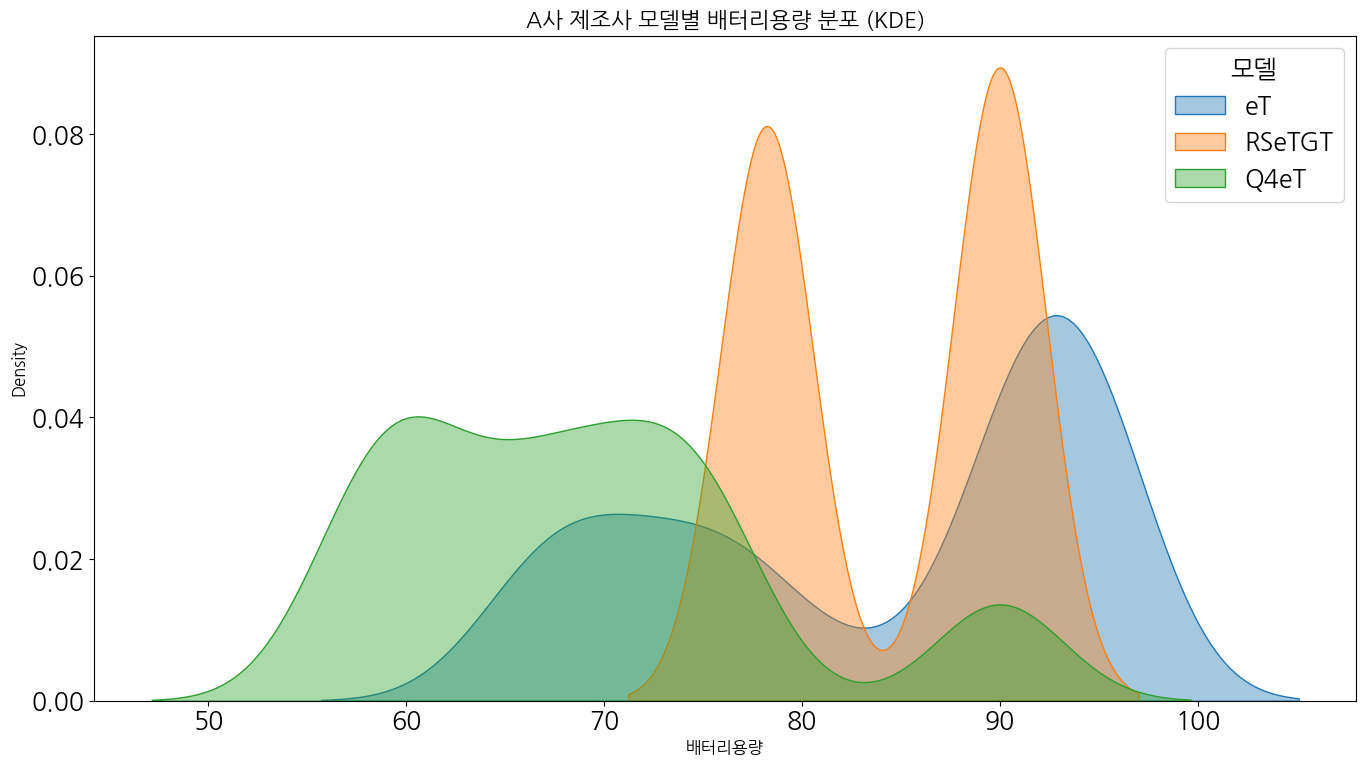

KeyboardInterrupt: 

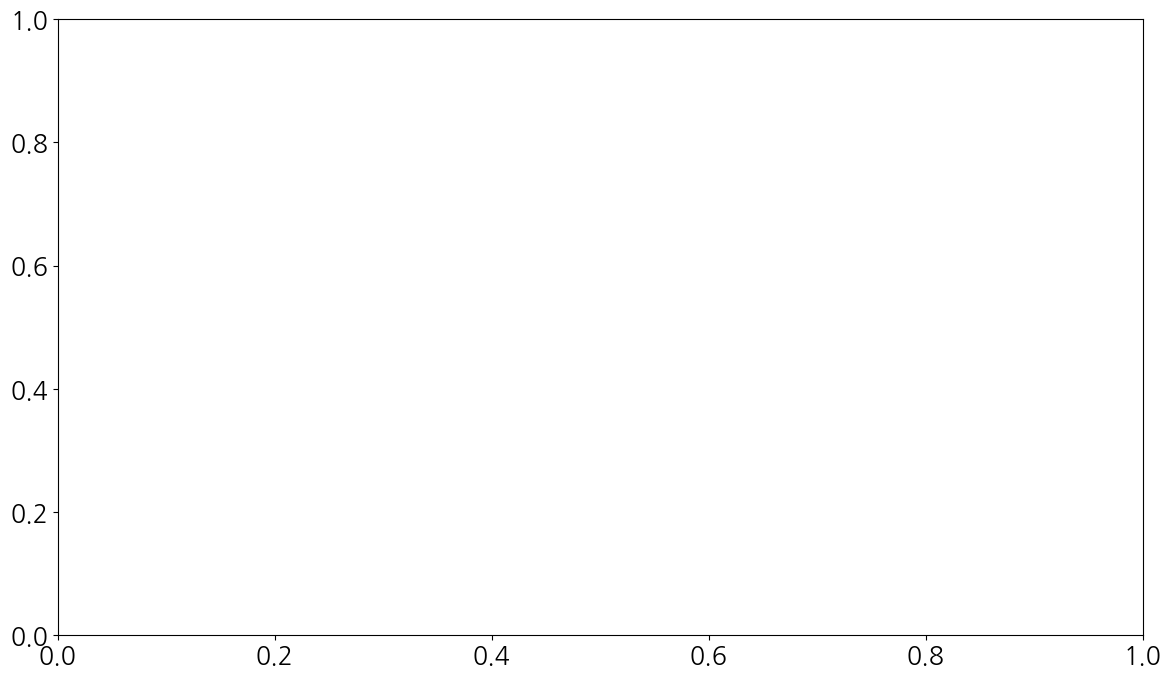

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 제조사 리스트 가져오기
manufacturers = train['제조사'].unique()

# 각 제조사별로 그래프를 그립니다.
for manufacturer in manufacturers:
    plt.figure(figsize=(14, 8))  # 각 그래프마다 크기를 설정
    manufacturer_data = train[train['제조사'] == manufacturer]

    # KDE 플롯: 모델별 배터리용량 분포
    for model in manufacturer_data['모델'].unique():
        model_data = manufacturer_data[manufacturer_data['모델'] == model]
        sns.kdeplot(
            model_data['배터리용량'],
            label=model,
            fill=True,
            alpha=0.4
        )

    # 그래프 제목과 레이블 설정
    plt.title(f'{manufacturer} 제조사 모델별 배터리용량 분포 (KDE)', fontsize=16)
    plt.xlabel('배터리용량', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # 범례 추가
    plt.legend(title='모델')

    # 그래프 표시
    plt.tight_layout()
    plt.show()

In [47]:
ordinal_features = ['제조사', '차량상태', '구동방식','사고이력',  '모델']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test[feature] = le.transform(test[feature])

In [48]:
model_mapping = dict(enumerate(le.classes_))
model_mapping

{0: 'EV6',
 1: 'ID4',
 2: 'ION5',
 3: 'ION6',
 4: 'IONIQ',
 5: 'KNE',
 6: 'M3',
 7: 'MS',
 8: 'MX',
 9: 'MY',
 10: 'Niro',
 11: 'Q4eT',
 12: 'RSeTGT',
 13: 'Soul',
 14: 'Tay',
 15: 'TayCT',
 16: 'TayGTS',
 17: 'eT',
 18: 'i3',
 19: 'i5',
 20: 'iX'}

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [16]:
train_notna = train[~train['배터리용량'].isna()].drop('ID',axis=1).reset_index(drop=True)
train_na = train[train['배터리용량'].isna()].drop('ID',axis=1).reset_index(drop=True)

In [17]:
train_notna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4786 entries, 0 to 4785
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   제조사       4786 non-null   object 
 1   모델        4786 non-null   object 
 2   차량상태      4786 non-null   object 
 3   배터리용량     4786 non-null   float64
 4   구동방식      4786 non-null   object 
 5   주행거리(km)  4786 non-null   int64  
 6   보증기간(년)   4786 non-null   int64  
 7   사고이력      4786 non-null   object 
 8   연식(년)     4786 non-null   int64  
 9   가격(백만원)   4786 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 374.0+ KB


In [18]:
train_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2711 entries, 0 to 2710
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   제조사       2711 non-null   object 
 1   모델        2711 non-null   object 
 2   차량상태      2711 non-null   object 
 3   배터리용량     0 non-null      float64
 4   구동방식      2711 non-null   object 
 5   주행거리(km)  2711 non-null   int64  
 6   보증기간(년)   2711 non-null   int64  
 7   사고이력      2711 non-null   object 
 8   연식(년)     2711 non-null   int64  
 9   가격(백만원)   2711 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 211.9+ KB


In [20]:
model_distribution = train_notna['모델'].value_counts()
model_distribution

,count
모델,
ID4,375
Niro,345
i5,335
eT,328
Soul,328
i3,327
TayGTS,259
KNE,243
ION6,235


In [19]:
model_distribution = train_na['모델'].value_counts()
model_distribution

,count
모델,
EV6,300
iX,291
RSeTGT,282
ID4,230
Q4eT,150
ION6,144
Tay,136
ION5,133
TayCT,127


In [37]:
summary_df = pd.DataFrame()

# 각 모델별 describe() 결과를 데이터프레임으로 저장
for model in train['모델'].unique():
    # describe() 결과 저장
    stats = train[train['모델'] == model]['배터리용량'].describe()
    # 결과를 데이터프레임에 추가 (컬럼 이름을 모델명으로 설정)
    summary_df[model] = stats

# 결과 출력
display(summary_df.iloc[:,:10])
display(summary_df.iloc[:,10:])

,TayGTS,Niro,eT,RSeTGT,i5,ION6,MS,MY,Q4eT,ID4
count,259.000000,345.000000,328.000000,103.000000,335.000000,235.000000,221.000000,179.000000,228.000000,375.00000
mean,80.454170,54.578933,83.776564,84.399252,65.493361,65.876923,89.672213,63.916380,69.040715,65.42444
std,11.090294,10.342878,10.719361,5.908311,7.284093,11.407106,10.961315,11.413747,9.526224,10.60358
min,64.683000,46.000000,65.791000,78.227000,56.234000,53.602000,69.253000,51.940000,56.788000,53.32500
25%,70.185000,48.093000,74.362000,78.227000,58.577000,58.162000,78.276000,56.359000,61.619000,57.86100
50%,76.156000,56.000000,91.200000,90.000000,63.560000,63.110000,96.000000,61.153000,66.861000,62.78400
75%,93.400000,56.623000,95.000000,90.000000,71.841000,68.479000,99.800000,66.355000,75.571000,68.12500
max,93.400000,90.000000,95.000000,90.000000,90.000000,90.000000,99.800000,90.000000,90.000000,90.00000


,TayCT,Soul,iX,MX,IONIQ,EV6,KNE,M3,i3,ION5,Tay
count,208.000000,328.00000,76.0,205.000000,108.000000,69.0,243.000000,169.000000,327.000000,220.000000,225.000000
mean,77.563933,53.71446,90.0,90.031151,62.044352,90.0,72.117597,64.482882,52.691131,66.439545,67.167316
std,4.287305,8.63604,0.0,11.367376,10.958746,0.0,8.073049,11.828421,8.790647,11.940341,10.879125
min,76.093000,46.00000,90.0,69.253000,46.090000,90.0,68.488000,51.940000,46.000000,53.602000,54.849000
25%,76.093000,46.16900,90.0,75.145000,52.745000,90.0,68.488000,56.359000,46.000000,58.162000,59.515000
50%,76.093000,56.00000,90.0,96.000000,60.875000,90.0,68.488000,61.153000,56.000000,63.110000,64.578000
75%,76.093000,56.62300,90.0,99.800000,68.725000,90.0,68.488000,66.355000,56.000000,71.332000,70.071000
max,90.000000,90.00000,90.0,99.800000,88.080000,90.0,90.000000,90.000000,90.000000,90.000000,90.000000


In [49]:
# iX, EV6 제외
new_train = train[~train['모델'].isin([0, 20])]

In [50]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6761 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        6761 non-null   object 
 1   제조사       6761 non-null   int64  
 2   모델        6761 non-null   int64  
 3   차량상태      6761 non-null   int64  
 4   배터리용량     4641 non-null   float64
 5   구동방식      6761 non-null   int64  
 6   주행거리(km)  6761 non-null   int64  
 7   보증기간(년)   6761 non-null   int64  
 8   사고이력      6761 non-null   int64  
 9   연식(년)     6761 non-null   int64  
 10  가격(백만원)   6761 non-null   float64
dtypes: float64(2), int64(8), object(1)
memory usage: 633.8+ KB


In [51]:
train_not = new_train[~(new_train['배터리용량'].isna())].reset_index(drop=True)
train_na = new_train[(new_train['배터리용량'].isna())].reset_index(drop=True)

In [56]:
# All_data
X_train_all = train_not.drop(columns=['ID', '가격(백만원)','배터리용량'])
y_train_all = train_not['배터리용량']
model_column_1 = train_not['모델']

In [62]:
class SklearnCompatibleRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# 모델 정의
xgb_model = SklearnCompatibleRegressor(XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=41))
cat_model = SklearnCompatibleRegressor(CatBoostRegressor(n_estimators=500, learning_rate=0.05, random_state=41, verbose=0))
lgb_model = SklearnCompatibleRegressor(LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=41))

# Voting Regressors 정의
voting_models = {
    'XGB+Cat': VotingRegressor([('xgb', xgb_model), ('cat', cat_model)]),
    'XGB+LGB': VotingRegressor([('xgb', xgb_model), ('lgb', lgb_model)]),
    'Cat+LGB': VotingRegressor([('cat', cat_model), ('lgb', lgb_model)]),
    'XGB+Cat+LGB': VotingRegressor([('xgb', xgb_model), ('cat', cat_model), ('lgb', lgb_model)])
}

In [63]:
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=41)

rmse_results = {
    'XGB': [],
    'CatBoost': [],
    'LGB': [],
    'XGB+Cat': [],
    'XGB+LGB': [],
    'Cat+LGB': [],
    'XGB+Cat+LGB': []
}

# 결과 저장용 리스트
fold_stats_list = []

# Stratified K-Fold 실행
for fold, (train_idx, valid_idx) in enumerate(stratified_kfold.split(X_train_all, model_column_1)):
    print(f"Fold {fold + 1}")

    # 훈련 및 검증 데이터 분리
    X_train_fold = X_train_all.iloc[train_idx]
    X_valid_fold = X_train_all.iloc[valid_idx]
    y_train_fold = y_train_all.iloc[train_idx]
    y_valid_fold = y_train_all.iloc[valid_idx]

    # 개별 모델 학습
    xgb_model.fit(X_train_fold, y_train_fold)
    lgb_model.fit(X_train_fold, y_train_fold)
    cat_model.fit(X_train_fold, y_train_fold)

    # Voting 모델 학습
    for name, voting_model in voting_models.items():
        voting_model.fit(X_train_fold, y_train_fold)

    # 예측 수행
    y_pred_xgb = xgb_model.predict(X_valid_fold)
    y_pred_lgb = lgb_model.predict(X_valid_fold)
    y_pred_cat = cat_model.predict(X_valid_fold)

    # 결과 저장 DataFrame 생성
    result_df = pd.DataFrame(X_valid_fold)
    result_df['배터리용량'] = y_valid_fold.values  # 타겟을 '배터리용량'으로 변경
    result_df['XGB_Pred'] = y_pred_xgb
    result_df['CatBoost_Pred'] = y_pred_cat
    result_df['LGB_Pred'] = y_pred_lgb

    # 각 Voting 모델에 대한 예측
    for name, voting_model in voting_models.items():
        result_df[f'{name}_Pred'] = voting_model.predict(X_valid_fold)

    # RMSE 계산
    result_df['xgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB_Pred'])**2)
    result_df['cat-real'] = np.sqrt((result_df['배터리용량'] - result_df['CatBoost_Pred'])**2)
    result_df['lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['LGB_Pred'])**2)
    result_df['xgb_cat-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB+Cat_Pred'])**2)
    result_df['xgb_lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB+LGB_Pred'])**2)
    result_df['cat_lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['Cat+LGB_Pred'])**2)
    result_df['xgb_cat_lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB+Cat+LGB_Pred'])**2)

    # 모델별 RMSE 계산
    rmse_results['XGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB_Pred'])))
    rmse_results['CatBoost'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['CatBoost_Pred'])))
    rmse_results['LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['LGB_Pred'])))
    rmse_results['XGB+Cat'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB+Cat_Pred'])))
    rmse_results['XGB+LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB+LGB_Pred'])))
    rmse_results['Cat+LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['Cat+LGB_Pred'])))
    rmse_results['XGB+Cat+LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB+Cat+LGB_Pred'])))

    # 모델별 통계 계산
    fold_stats = result_df.groupby('모델')[['xgb-real', 'cat-real', 'lgb-real',
                                            'xgb_cat-real', 'xgb_lgb-real',
                                            'cat_lgb-real', 'xgb_cat_lgb-real']].agg(['mean', 'std'])
    fold_stats_list.append(fold_stats)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 3712, number of used features: 8
[LightGBM] [Info] Start training from score 68.647175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 3712, number of used features: 8
[LightGBM] [Info] Start training from score 68.647175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train s

In [64]:
model_stats_mean = pd.concat(fold_stats_list).groupby('모델').mean()
# 'mean' 열만 필터링
mean_columns = [col for col in model_stats_mean.columns if col[1] == 'mean']

# 스타일링 함수 정의
def highlight_minimum(s):
    is_min = s == s.min()  # 최소값 여부 확인
    return ['background-color: lightgreen' if v else '' for v in is_min]
display(model_stats_mean.style.apply(
    highlight_minimum,
    subset=mean_columns,
    axis=1  # 행별로 적용
))

In [ ]:
#상한값 적용

In [68]:
# 모델 인코딩 정보
model_encoding = {
    0: 'EV6', 1: 'ID4', 2: 'ION5', 3: 'ION6', 4: 'IONIQ', 5: 'KNE', 6: 'M3', 7: 'MS',
    8: 'MX', 9: 'MY', 10: 'Niro', 11: 'Q4eT', 12: 'RSeTGT', 13: 'Soul', 14: 'Tay',
    15: 'TayCT', 16: 'TayGTS', 17: 'eT', 18: 'i3', 19: 'i5', 20: 'iX'
}

# 조건별 제한 값 정의
max_battery_limits = {
    'Niro': 90, 'RSeTGT': 90, 'i5': 90, 'ION6': 90, 'MY': 90, 'Q4eT': 90, 'ID4': 90,
    'TayCT': 90, 'Soul': 90, 'KNE': 90, 'M3': 90, 'i3': 90, 'ION5': 90, 'Tay': 90,
    'TayGTS': 93.4, 'eT': 95, 'MS': 99.8, 'MX': 99.8
}

rmse_results = {
    'XGB': [],
    'CatBoost': [],
    'LGB': [],
    'XGB+Cat': [],
    'XGB+LGB': [],
    'Cat+LGB': [],
    'XGB+Cat+LGB': []
}

# Stratified K-Fold 실행 (조건 추가된 버전)
for fold, (train_idx, valid_idx) in enumerate(stratified_kfold.split(X_train_all, model_column_1)):
    print(f"Fold {fold + 1}")

    # 훈련 및 검증 데이터 분리
    X_train_fold = X_train_all.iloc[train_idx]
    X_valid_fold = X_train_all.iloc[valid_idx]
    y_train_fold = y_train_all.iloc[train_idx]
    y_valid_fold = y_train_all.iloc[valid_idx]

    # 개별 모델 학습
    xgb_model.fit(X_train_fold, y_train_fold)
    lgb_model.fit(X_train_fold, y_train_fold)
    cat_model.fit(X_train_fold, y_train_fold)

    # Voting 모델 학습
    for name, voting_model in voting_models.items():
        voting_model.fit(X_train_fold, y_train_fold)

    # 예측 수행
    y_pred_xgb = xgb_model.predict(X_valid_fold)
    y_pred_lgb = lgb_model.predict(X_valid_fold)
    y_pred_cat = cat_model.predict(X_valid_fold)

    # 결과 저장 DataFrame 생성
    result_df = pd.DataFrame(X_valid_fold)
    result_df['배터리용량'] = y_valid_fold.values
    result_df['XGB_Pred'] = y_pred_xgb
    result_df['CatBoost_Pred'] = y_pred_cat
    result_df['LGB_Pred'] = y_pred_lgb

    # 각 Voting 모델에 대한 예측
    for name, voting_model in voting_models.items():
        result_df[f'{name}_Pred'] = voting_model.predict(X_valid_fold)

    # 모델별 조건 적용
    for column in result_df.filter(regex='_Pred$').columns:
        for model_code, model_name in model_encoding.items():
            if model_name in max_battery_limits:
                max_limit = max_battery_limits[model_name]
                result_df.loc[result_df['모델'] == model_code, column] = result_df.loc[
                    result_df['모델'] == model_code, column
                ].clip(upper=max_limit)

    # RMSE 계산
    result_df['xgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB_Pred'])**2)
    result_df['cat-real'] = np.sqrt((result_df['배터리용량'] - result_df['CatBoost_Pred'])**2)
    result_df['lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['LGB_Pred'])**2)
    result_df['xgb_cat-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB+Cat_Pred'])**2)
    result_df['xgb_lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB+LGB_Pred'])**2)
    result_df['cat_lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['Cat+LGB_Pred'])**2)
    result_df['xgb_cat_lgb-real'] = np.sqrt((result_df['배터리용량'] - result_df['XGB+Cat+LGB_Pred'])**2)

    # 모델별 RMSE 계산
    rmse_results['XGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB_Pred'])))
    rmse_results['CatBoost'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['CatBoost_Pred'])))
    rmse_results['LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['LGB_Pred'])))
    rmse_results['XGB+Cat'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB+Cat_Pred'])))
    rmse_results['XGB+LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB+LGB_Pred'])))
    rmse_results['Cat+LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['Cat+LGB_Pred'])))
    rmse_results['XGB+Cat+LGB'].append(np.sqrt(mean_squared_error(result_df['배터리용량'], result_df['XGB+Cat+LGB_Pred'])))

    # 모델별 통계 계산
    fold_stats = result_df.groupby('모델')[['xgb-real', 'cat-real', 'lgb-real',
                                            'xgb_cat-real', 'xgb_lgb-real',
                                            'cat_lgb-real', 'xgb_cat_lgb-real']].agg(['mean', 'std'])
    fold_stats_list.append(fold_stats)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 3712, number of used features: 8
[LightGBM] [Info] Start training from score 68.647175
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 3712, number of used features: 8
[LightGBM] [Info] Start training from score 68.647175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total

In [69]:
score_41 = pd.DataFrame(rmse_results)
score_41.loc['Mean'] = score_41.mean()
score_41

,XGB,CatBoost,LGB,XGB+Cat,XGB+LGB,Cat+LGB,XGB+Cat+LGB
0,2.461571,2.348553,2.328788,2.375181,2.368229,2.296777,2.335770
1,2.546615,2.044185,2.122710,2.249476,2.284727,2.051850,2.180494
2,2.236674,2.001584,2.014115,2.090213,2.094751,1.977130,2.043922
3,2.343759,2.024597,2.056776,2.133052,2.110042,1.994516,2.057467
4,2.322682,2.082715,2.083051,2.170010,2.162317,2.055921,2.118011
Mean,2.382260,2.100327,2.121088,2.203586,2.204013,2.075239,2.147133


In [66]:
model_stats_mean_maxlimit = pd.concat(fold_stats_list).groupby('모델').mean()
# 'mean' 열만 필터링
mean_columns = [col for col in model_stats_mean_maxlimit.columns if col[1] == 'mean']

# 스타일링 함수 정의
def highlight_minimum(s):
    is_min = s == s.min()  # 최소값 여부 확인
    return ['background-color: lightgreen' if v else '' for v in is_min]
display(model_stats_mean_maxlimit.style.apply(
    highlight_minimum,
    subset=mean_columns,
    axis=1  # 행별로 적용
))

In [67]:
display(model_stats_mean.style.apply(
    highlight_minimum,
    subset=mean_columns,
    axis=1  # 행별로 적용
))

display(model_stats_mean_maxlimit.style.apply(
    highlight_minimum,
    subset=mean_columns,
    axis=1  # 행별로 적용
))